In [1]:
from fastai.vision.all import *
import re
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from enveco.data.image import *
from enveco.metrics import *
from enveco.interpretation import *

import rasterio as rio

In [2]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [3]:
def plot_gradcam(learner, inp, ax, target_class=None, target_layer=None, im_cls=TensorImage, **plot_kws):
    "If target class is not specified, calculate in respect to prediction"
    if target_class is None:
        with torch.no_grad(): target_class = learner.model.eval()(inp[None].cuda()).argmax().item()
            
    if target_layer is None:
        with HookBwd(learner.model[0]) as hookg:
            with Hook(learner.model[0]) as hook:
                outp = learner.model.eval()(inp[None].cuda())
                act = hook.stored
            outp[0, target_class].backward()
            grad = hookg.stored
    else:
        with HookBwd(learner.model[0][target_layer]) as hookg:
            with Hook(learner.model[0][target_layer]) as hook:
                outp = learner.model.eval()(inp[None].cuda())
                act = hook.stored
            outp[0, target_class].backward()
            grad = hookg.stored        

    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    im_cls(learner.dls.train.decode((inp,))[0][0]).show(ctx=ax, **plot_kws)
    
    ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,inp.shape[-1],inp.shape[-1],0),
              interpolation='bilinear', cmap='magma')
    return ax

# Read data, preprocess and get mean/std

In [6]:
data_path = Path('../../../andras/ml/AV_leafon')

In [7]:
train_df = pd.read_csv(data_path/'AV.leaf.on.train.csv')
train_df = train_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

valid_df = pd.read_csv(data_path/'AV.leaf.on.val.csv')
valid_df = valid_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

test_df = pd.read_csv(data_path/'AV.leaf.on.test.csv')
test_df = test_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

In [8]:
outpath = Path('../../data')
if not os.path.exists(outpath): os.makedirs(outpath)


In [10]:
rawims = []
for row in train_df.itertuples():
    with rio.open(data_path/f'AV_tif/{row.sampleplotid}.tif') as src:
        vals = src.read().astype(np.float32)
    rawims.append(vals / 255.)

In [11]:
rawimsarr = np.array(rawims)
rawimsarr.shape

(1044, 3, 61, 61)

In [12]:
rawims = None

In [13]:
means = np.nanmean(rawimsarr, axis=(0,2,3))
stds = np.nanstd(rawimsarr, axis=(0,2,3))
stats = np.array((means, stds))


In [183]:
def tree_pcts(row):
    pcts = [np.round(row.v_ma/row.v,2), np.round(row.v_ku/row.v,2), np.round(row.v_lp/row.v,2)]
    return pcts

In [99]:
def species_in_plot(row):
    retspecies = ''
    if row.rel_v_ma > 0.0: retspecies = retspecies + 'Pine;'
    if row.rel_v_ku > 0.0: retspecies = retspecies + 'Spruce;'
    if row.rel_v_lp > 0.0: retspecies = retspecies + 'Broadleaf;'
    return retspecies[:-1]

In [30]:
np.ceil(0.02 * 10) 

1.0

In [59]:
def dist_classes(sp_pct):
    labels = [f'q{i}' for i in range(0, 10)]
    return labels[int(np.ceil(sp_pct * 10))-1]

In [74]:
def maj_species(row):
    vals = [row.rel_v_ma, row.rel_v_ku, row.rel_v_lp]
    species = ['Pine', 'Spruce', 'Broadleaved']
    return species[vals.index(max(vals))]

In [100]:
def species_present(sp_pct):
    if sp_pct > 0.05: return 1
    return 0

In [184]:
train_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = train_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')
valid_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = valid_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')
test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = test_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')

In [143]:
train_df['species_in_plot'] = train_df.apply(lambda row: species_in_plot(row), axis=1)
test_df['species_in_plot'] = test_df.apply(lambda row: species_in_plot(row), axis=1)
valid_df['species_in_plot'] = valid_df.apply(lambda row: species_in_plot(row), axis=1)

In [62]:
train_df['pine_proportion_cls'] = train_df.apply(lambda row: dist_classes(row.rel_v_ma), axis=1)
valid_df['pine_proportion_cls'] = valid_df.apply(lambda row: dist_classes(row.rel_v_ma), axis=1)
test_df['pine_proportion_cls'] = test_df.apply(lambda row: dist_classes(row.rel_v_ma), axis=1)


In [110]:
train_df['pine_present'] = train_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)
valid_df['pine_present'] = valid_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)
test_df['pine_present'] = test_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)


In [111]:
train_df['spruce_present'] = train_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)
valid_df['spruce_present'] = valid_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)
test_df['spruce_present'] = test_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)

In [112]:
train_df['broadleaf_present'] = train_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)
valid_df['broadleaf_present'] = valid_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)
test_df['broadleaf_present'] = test_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)

In [113]:
train_df.spruce_present.value_counts()

0    556
1    488
Name: spruce_present, dtype: int64

In [114]:
train_df['major_species'] = train_df.apply(lambda row: maj_species(row), axis=1)
valid_df['major_species'] = valid_df.apply(lambda row: maj_species(row), axis=1)
test_df['major_species'] = test_df.apply(lambda row: maj_species(row), axis=1)


# Make learner

In [188]:
train_df['is_val'] = 0
valid_df['is_val'] = 1
trainval_df = pd.concat((train_df, valid_df))

In [208]:
dls = ImageDataLoaders.from_df(trainval_df, path=data_path/'AV_tif', fn_col='sampleplotid',
                               suff='.tif', label_col='v',#['rel_v_ma', 'rel_v_ku', 'rel_v_lp'], 
                               #y_block=CategoryBlock,
                               y_block=RegressionBlock(n_out=1),
                               #y_block=MultiCategoryBlock,
                               valid_col='is_val', #label_delim=';',
                               batch_tfms=[
                                   Normalize.from_stats(*stats),
                                   Dihedral(),
                                   Brightness(max_lighting=0.2),
                                   Contrast(max_lighting=0.2)
                                ])

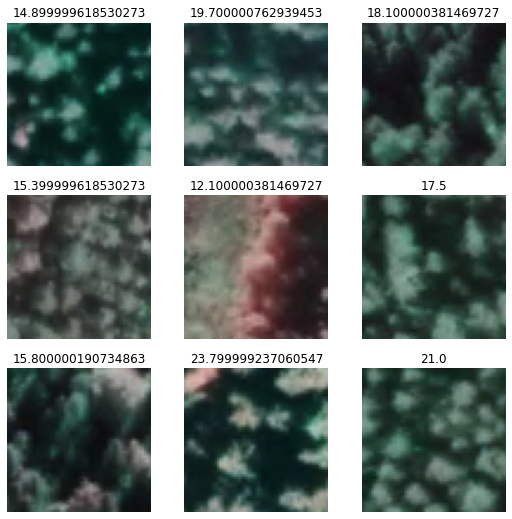

In [201]:
dls.show_batch()

In [191]:
f1_multi = F1ScoreMulti(average='micro')
pre_multi = PrecisionMulti(average='micro')
rec_multi = RecallMulti(average='micro')

In [209]:
model = cnn_learner(dls, resnet50, pretrained=False, 
                    
                    #metrics=[accuracy_multi, f1_multi, pre_multi, rec_multi], 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                    #metrics = [accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')], loss_func=LabelSmoothingCrossEntropy(),
                    y_range=(0,900),
                    path='.', model_dir='models')

In [210]:
model.summary()

Sequential (Input shape: ['64 x 3 x 61 x 61'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 31 x 31    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 31 x 31    128        True      
________________________________________________________________
ReLU                 64 x 64 x 31 x 31    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 16 x 16    0          False     
________________________________________________________________
Conv2d               64 x 64 x 16 x 16    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 16 x 16    128        True      
________________________________________________________________
Conv2d               64 x 64 x 16 x 16    36,864     True      
___________________________________________________

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0004786300996784121)

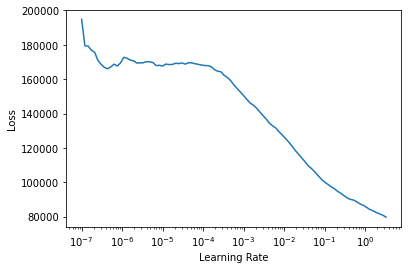

In [211]:
model.lr_find()

In [212]:
model.fit_one_cycle(50, max_lr=1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,161566.515625,11516.709961,107.315933,71.179222,-28.064924,-18.614567,77.281578,-0.265461,00:01
1,153565.234375,20192.601562,142.100677,94.250832,51.644085,34.253872,111.720718,-1.218772,00:01
2,136805.406250,45740.523438,213.870346,141.853363,85.458870,56.682133,143.649399,-4.025988,00:01
3,117856.101562,43281.324219,208.041656,137.987381,47.731224,31.658596,132.760284,-3.755771,00:01
4,102508.437500,40580.343750,201.445648,133.612457,36.105770,23.947802,122.666901,-3.458986,00:01
5,89048.320312,39883.957031,199.709656,132.461029,21.481218,14.247805,129.100342,-3.382466,00:01
6,80459.593750,43283.335938,208.046478,137.990570,19.535910,12.957543,124.695969,-3.755992,00:01
7,72137.351562,28303.357422,168.236008,111.585556,-24.615248,-16.326506,107.561958,-2.109985,00:01
8,64192.296875,29995.060547,173.190826,114.871933,-51.684292,-34.280537,117.352013,-2.295870,00:01
9,57149.183594,26664.296875,163.292053,108.306396,-59.720440,-39.610657,104.418671,-1.929884,00:01


TypeError: bad operand type for unary +: 'NoneType'

In [180]:
interp = ClassificationInterpretation.from_learner(model)

AttributeError: vocab

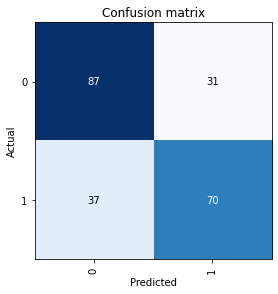

In [142]:
interp.plot_confusion_matrix()

In [133]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       118
           1       0.71      0.71      0.71       107

    accuracy                           0.72       225
   macro avg       0.72      0.72      0.72       225
weighted avg       0.72      0.72      0.72       225



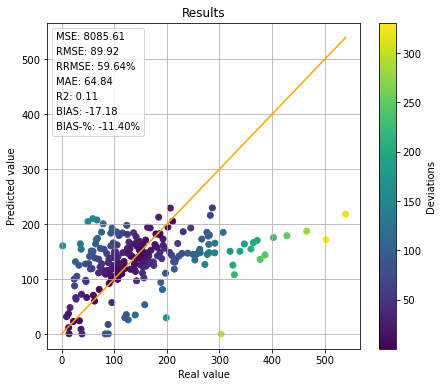

In [213]:
reg_interp = RegressionInterpretation.from_learner(model)
reg_interp.plot_results(log_y=False)
plt.show()

In [197]:
preds, targs = model.get_preds()

In [25]:
tots = preds[:,0] + preds[:,1] + preds[:,2]

In [31]:
preds.shape

torch.Size([225, 3])

In [33]:
tots[None].shape

torch.Size([1, 225])

In [34]:
scaled_preds = preds / tots[:,None]

In [35]:
scaled_tots = scaled_preds[:,0] + scaled_preds[:,1] + scaled_preds[:,2]

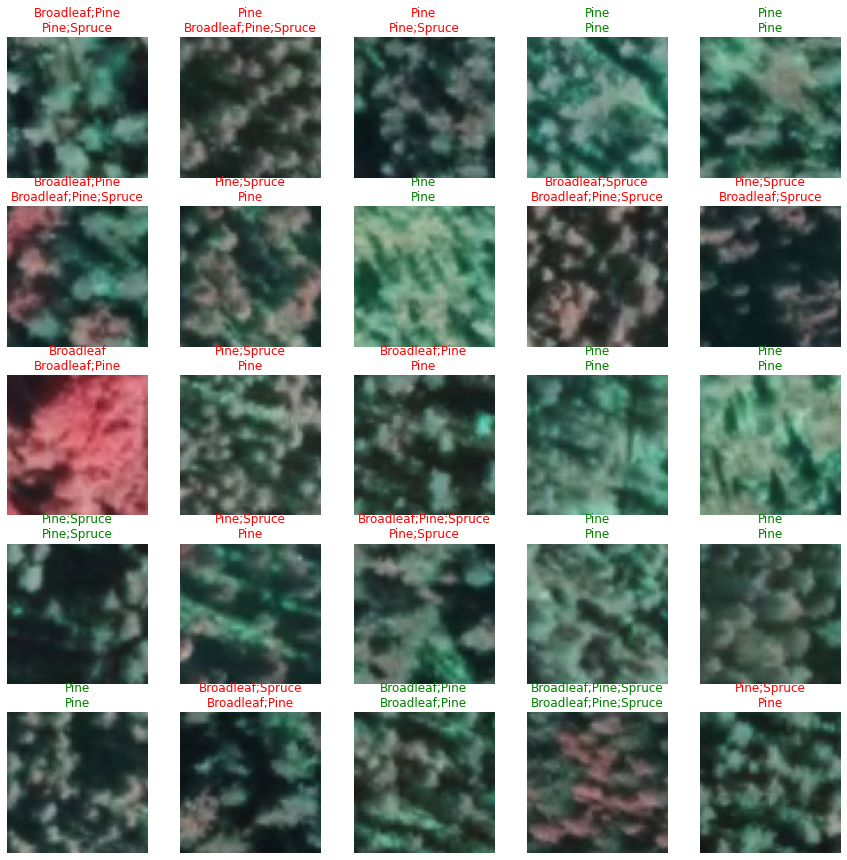

In [153]:
model.show_results(max_n=25)

In [154]:
preds, targs = model.get_preds()

In [155]:
species = dls.vocab

Results for Broadleaf
              precision    recall  f1-score   support

      Absent       0.69      0.72      0.71       118
     Present       0.68      0.64      0.66       107

    accuracy                           0.68       225
   macro avg       0.68      0.68      0.68       225
weighted avg       0.68      0.68      0.68       225

Results for Pine
              precision    recall  f1-score   support

      Absent       0.46      0.32      0.37        19
     Present       0.94      0.97      0.95       206

    accuracy                           0.91       225
   macro avg       0.70      0.64      0.66       225
weighted avg       0.90      0.91      0.90       225

Results for Spruce
              precision    recall  f1-score   support

      Absent       0.72      0.75      0.73       118
     Present       0.71      0.68      0.70       107

    accuracy                           0.72       225
   macro avg       0.72      0.71      0.71       225
weighted avg    

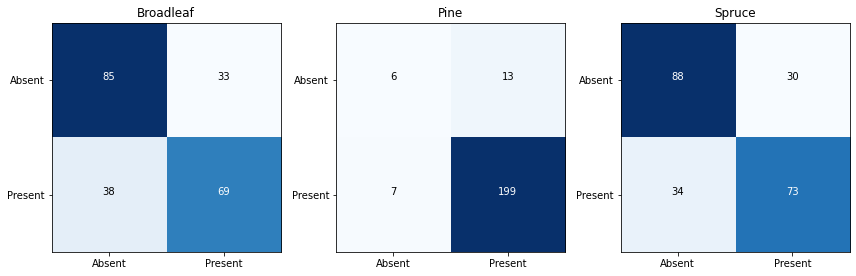

In [156]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

fig, axs = plt.subplots(1,3, figsize=(12,5))

for i in range(len(species)):
    print(f'Results for {species[i]}')
    temp_preds = preds[:,i].numpy().copy()
    temp_preds[temp_preds < 0.5] = 0
    temp_preds[temp_preds >= 0.5] = 1
    print(classification_report(targs[:,i], temp_preds, target_names=['Absent', 'Present']))
    
    cm = confusion_matrix(targs[:,i], temp_preds)
    axs[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axs[i].set_title(species[i])
    axs[i].set_xticks(np.arange(2))
    axs[i].set_yticks(np.arange(2))
    axs[i].set_xticklabels(['Absent', 'Present'])
    axs[i].set_yticklabels(['Absent', 'Present'])
    tresh = cm.max()/1.5
    for j, k in product(range(2), range(2)):
        axs[i].text(k, j, f'{cm[j,k]}',
                    horizontalalignment='center',
                    color='white' if cm[j,k] > tresh else 'black')
plt.tight_layout()

In [198]:
test_dl = dls.test_dl(test_df, with_labels=True)

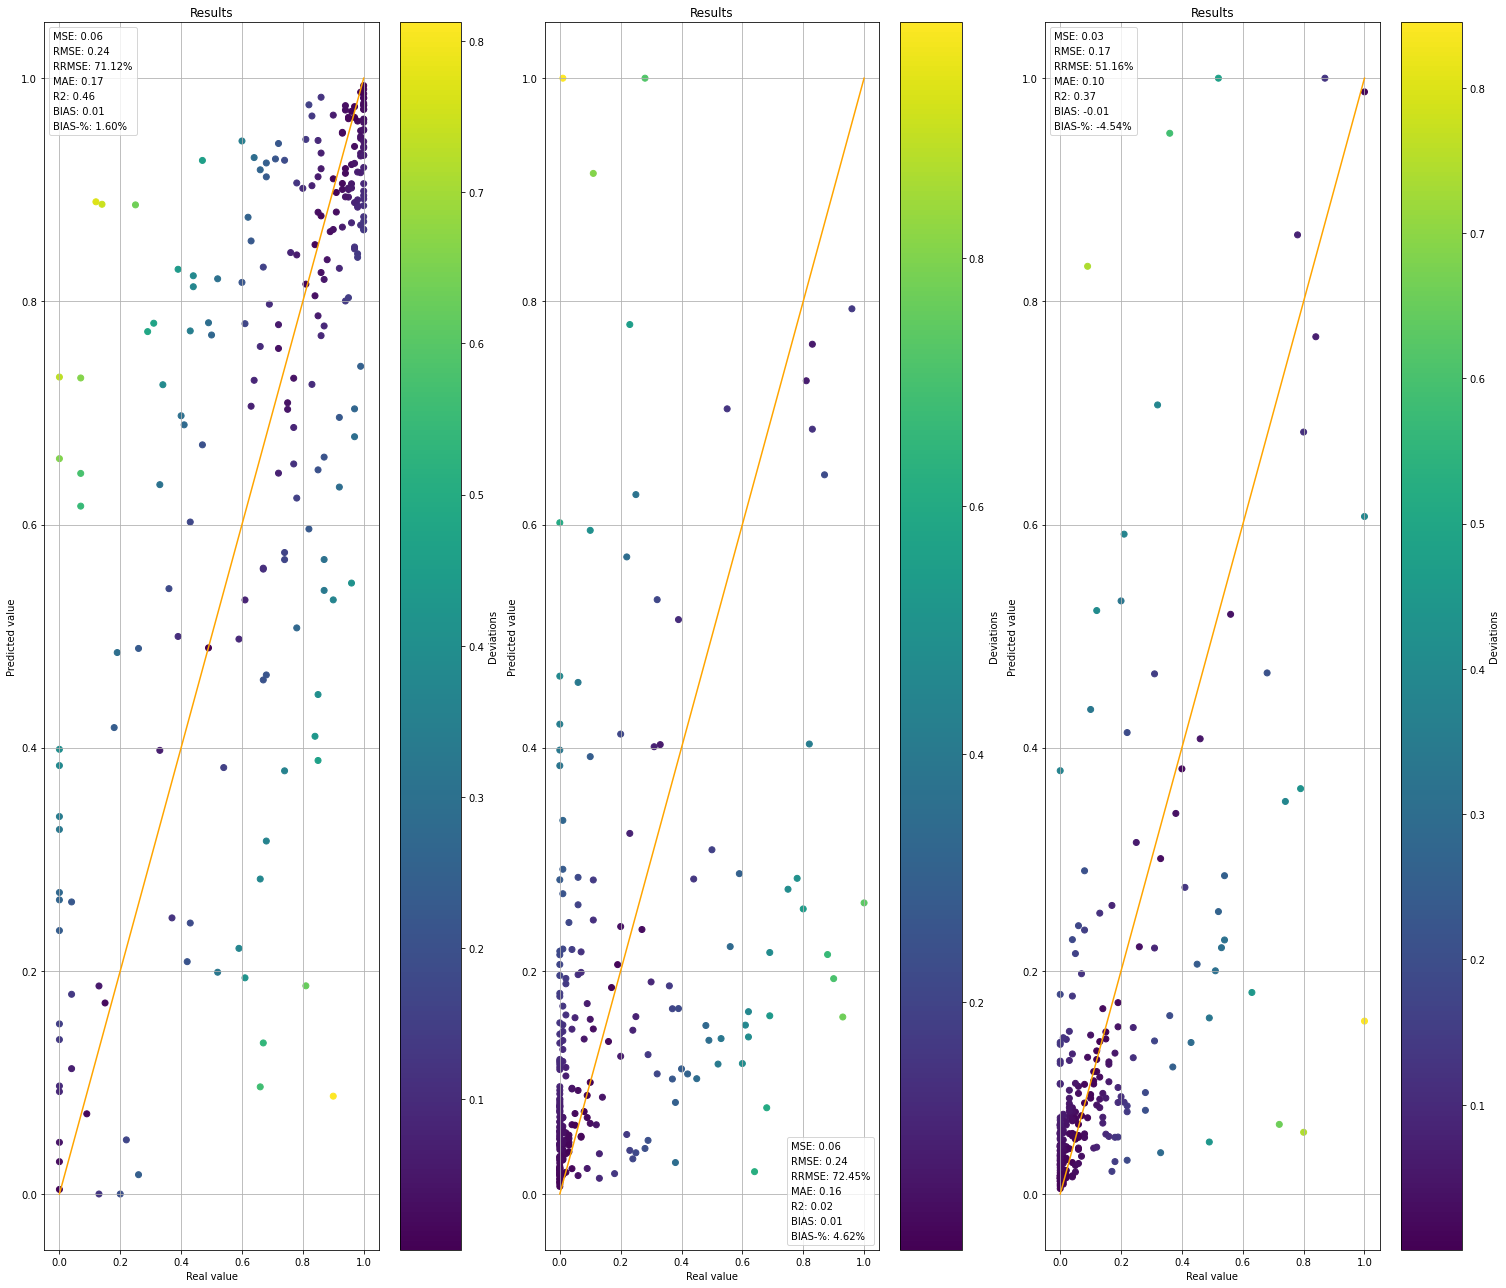

In [199]:
reg_interp = RegressionInterpretation.from_learner(model, dl=test_dl)
reg_interp.plot_results(log_y=False)
plt.tight_layout()
plt.show()


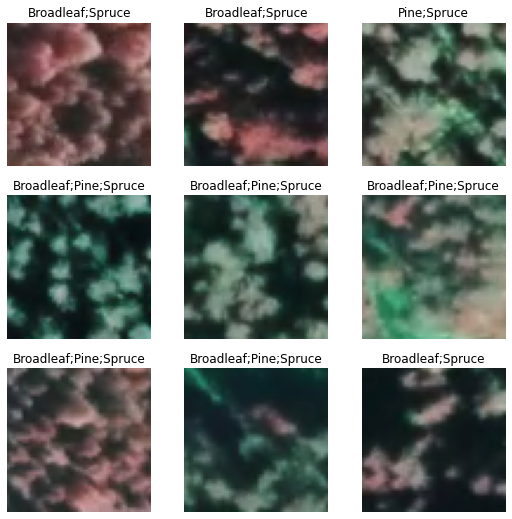

In [105]:
test_dl.show_batch()

Results for Broadleaf
              precision    recall  f1-score   support

      Absent       0.64      0.68      0.66       109
     Present       0.68      0.64      0.66       116

    accuracy                           0.66       225
   macro avg       0.66      0.66      0.66       225
weighted avg       0.66      0.66      0.66       225

Results for Pine
              precision    recall  f1-score   support

      Absent       0.62      0.26      0.37        19
     Present       0.94      0.99      0.96       206

    accuracy                           0.92       225
   macro avg       0.78      0.62      0.67       225
weighted avg       0.91      0.92      0.91       225

Results for Spruce
              precision    recall  f1-score   support

      Absent       0.74      0.75      0.75       126
     Present       0.68      0.67      0.67        99

    accuracy                           0.72       225
   macro avg       0.71      0.71      0.71       225
weighted avg    

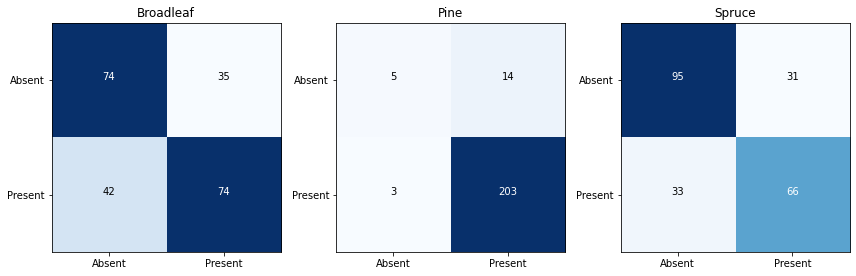

In [158]:
preds, targs = model.get_preds(dl=test_dl)
fig, axs = plt.subplots(1,3, figsize=(12,5))

for i in range(len(species)):
    print(f'Results for {species[i]}')
    temp_preds = preds[:,i].numpy().copy()
    temp_preds[temp_preds < 0.5] = 0
    temp_preds[temp_preds >= 0.5] = 1
    print(classification_report(targs[:,i], temp_preds, target_names=['Absent', 'Present']))
    
    cm = confusion_matrix(targs[:,i], temp_preds)
    axs[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axs[i].set_title(species[i])
    axs[i].set_xticks(np.arange(2))
    axs[i].set_yticks(np.arange(2))
    axs[i].set_xticklabels(['Absent', 'Present'])
    axs[i].set_yticklabels(['Absent', 'Present'])
    tresh = cm.max()/1.5
    for j, k in product(range(2), range(2)):
        axs[i].text(k, j, f'{cm[j,k]}',
                    horizontalalignment='center',
                    color='white' if cm[j,k] > tresh else 'black')
plt.tight_layout()

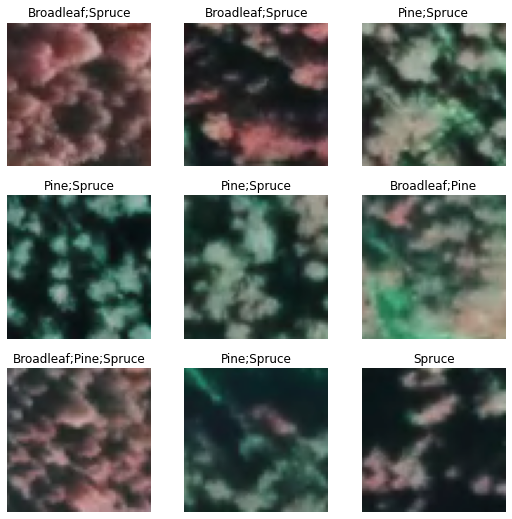

In [159]:
test_dl.show_batch()

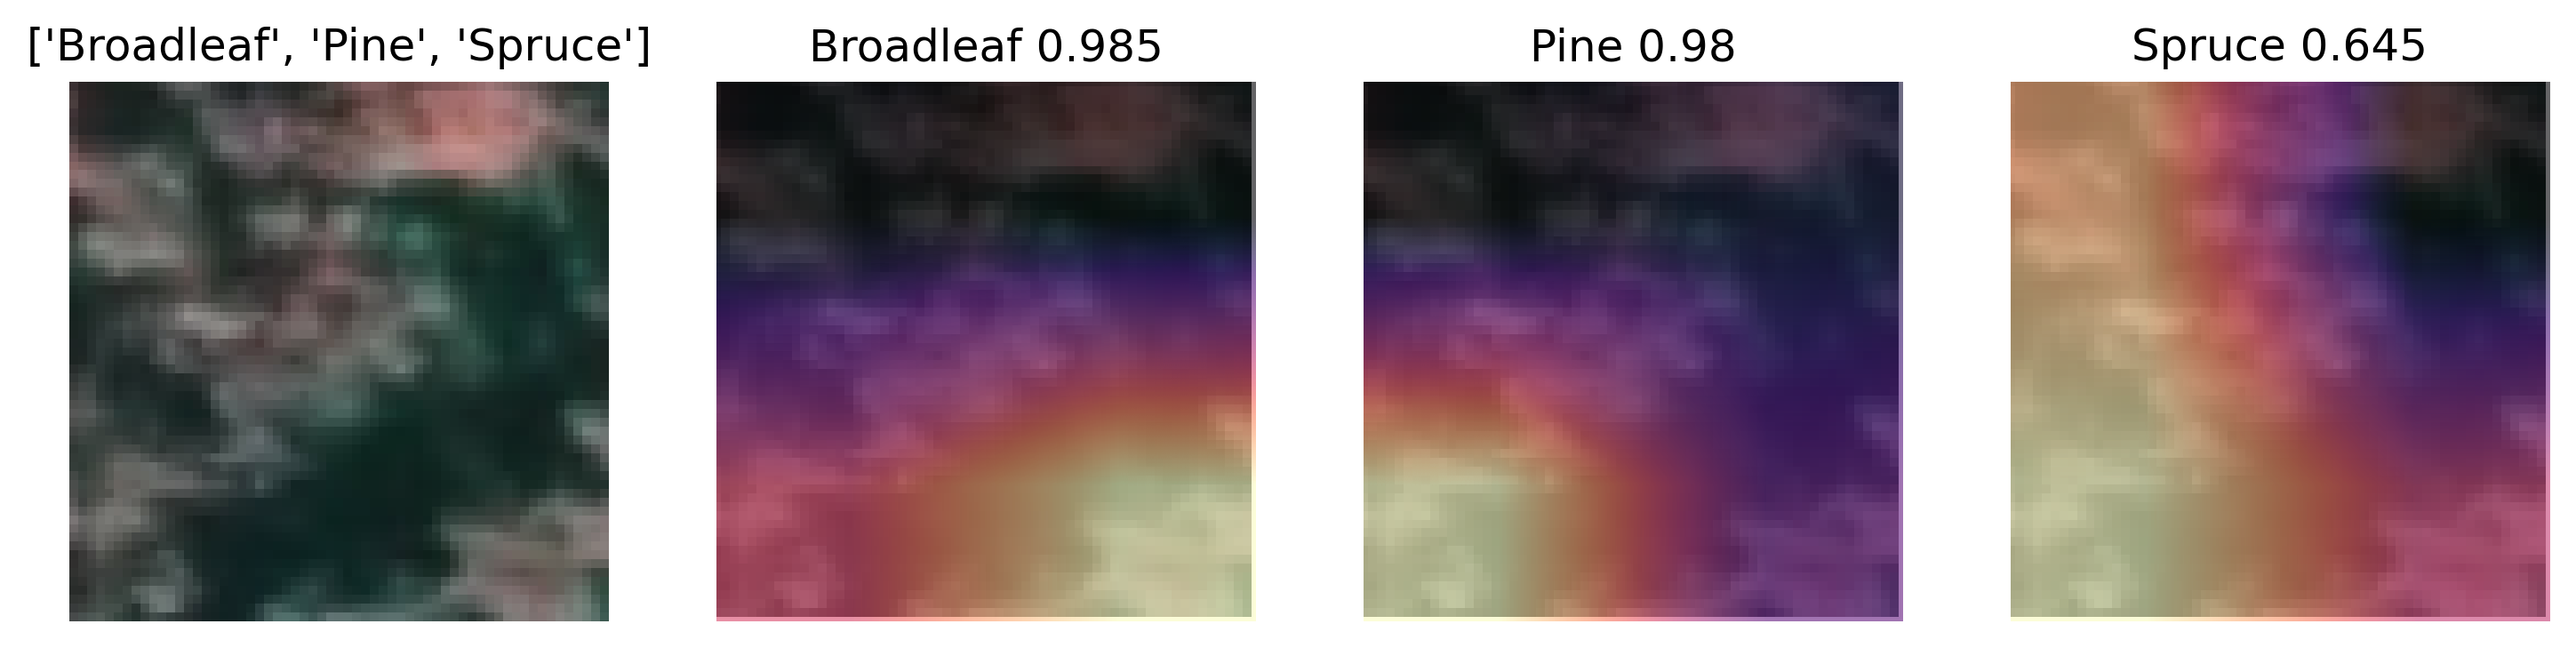

In [160]:
batch = test_dl.one_batch()
sigmoid = nn.Sigmoid()
targ_idx = np.random.randint(0, 64, 1)[0]
pred = sigmoid(model.model.eval()(batch[0]))[targ_idx]
pred_idx = [i for i in range_of(pred) if pred[i] > 0.5]
fig, ax = plt.subplots(1, 1+len(pred_idx), figsize=(4*len(pred_idx),4), dpi=300)
for i, ix in enumerate(pred_idx):
    plot_gradcam(model, batch[0][targ_idx], ax[i+1], target_class=ix,
                 im_cls=TensorImage)
    ax[i+1].set_title(f'{species[ix]} {round(pred[ix].cpu().detach().item(),3)}')
test_dl.decode_batch(batch, max_n=64)[targ_idx][0].show(ax=ax[0], title=test_dl.decode_batch(batch, max_n=64)[targ_idx][1])
plt.show()